In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.6 MB/s eta 0:00:00


In [5]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import numpy as np
import pandas as pd

import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch_geometric
from torch_geometric.nn import GCNConv

# Load the Cora dataset with feature normalization
# 'root' specifies where to store the data
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset.name}')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Graph data object: {data}')

Dataset: Cora
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Graph data object: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Simple GCN

In [48]:
class SimpleGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2_list = nn.ModuleList(GCNConv(hidden_channels, hidden_channels) for _ in range(num_layers - 2))
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        for conv in self.conv2_list:
            x = conv(x, edge_index)
            x = self.relu(x)
        x = self.conv3(x, edge_index)
        return x
    
    def forward_inspect(self, x, edge_index):
        inspections = {}
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        inspections['conv1'] = x.detach().cpu()
        for i, conv in enumerate(self.conv2_list):
            x = conv(x, edge_index)
            x = self.relu(x)
            inspections[f'conv{i+2}'] = x.detach().cpu()
        x = self.conv3(x, edge_index)
        inspections['conv_out'] = x.detach().cpu()
        return x, inspections

In [49]:
model_GCN = SimpleGCN(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes, num_layers=3).to(device)
optimizer = torch.optim.Adam(model_GCN.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

In [50]:
def train(model, data, optimizer, criterion, epochs=200):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x.to(device), data.edge_index.to(device))
        loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

In [51]:
def evaluate(model, data):
    model.eval()
    out = model(data.x.to(device), data.edge_index.to(device))
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask].to(device)).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc

In [52]:
train(model_GCN, data, torch.optim.Adam(model_GCN.parameters(), lr=0.01, weight_decay=5e-4), nn.CrossEntropyLoss(), epochs=200)

Epoch 20, Loss: 1.6907
Epoch 40, Loss: 0.8369
Epoch 60, Loss: 0.2686
Epoch 80, Loss: 0.1288
Epoch 100, Loss: 0.0838
Epoch 120, Loss: 0.0601
Epoch 140, Loss: 0.0464
Epoch 160, Loss: 0.0387
Epoch 180, Loss: 0.0340
Epoch 200, Loss: 0.0311


In [53]:
accuracy = evaluate(model_GCN, data)
print(f'GCN Test Accuracy: {accuracy:.4f}')

GCN Test Accuracy: 0.7730


## Test for number of layers

In [54]:
model_list = []
acc_list = []

test_range = range(2, 15)

for num_layers in test_range:
    model = SimpleGCN(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes, num_layers=num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    
    train(model, data, optimizer, criterion, epochs=200)
    accuracy = evaluate(model, data)
    
    model_list.append(model)
    acc_list.append(accuracy)
    
    print(f'Number of Layers: {num_layers}, Test Accuracy: {accuracy:.4f}')

Epoch 20, Loss: 1.7017
Epoch 40, Loss: 1.2182
Epoch 60, Loss: 0.7891
Epoch 80, Loss: 0.5497
Epoch 100, Loss: 0.4203
Epoch 120, Loss: 0.3426
Epoch 140, Loss: 0.2921
Epoch 160, Loss: 0.2574
Epoch 180, Loss: 0.2323
Epoch 200, Loss: 0.2134
Number of Layers: 2, Test Accuracy: 0.8140
Epoch 20, Loss: 1.6368
Epoch 40, Loss: 0.8338
Epoch 60, Loss: 0.2872
Epoch 80, Loss: 0.1291
Epoch 100, Loss: 0.0809
Epoch 120, Loss: 0.0603
Epoch 140, Loss: 0.0494
Epoch 160, Loss: 0.0432
Epoch 180, Loss: 0.0388
Epoch 200, Loss: 0.0357
Number of Layers: 3, Test Accuracy: 0.7810
Epoch 20, Loss: 1.6776
Epoch 40, Loss: 1.0390
Epoch 60, Loss: 0.3206
Epoch 80, Loss: 0.0810
Epoch 100, Loss: 0.0445
Epoch 120, Loss: 0.0305
Epoch 140, Loss: 0.0189
Epoch 160, Loss: 0.0117
Epoch 180, Loss: 0.0094
Epoch 200, Loss: 0.0088
Number of Layers: 4, Test Accuracy: 0.7380
Epoch 20, Loss: 1.5347
Epoch 40, Loss: 0.8492
Epoch 60, Loss: 0.4105
Epoch 80, Loss: 0.1752
Epoch 100, Loss: 0.0842
Epoch 120, Loss: 0.0506
Epoch 140, Loss: 0.0329

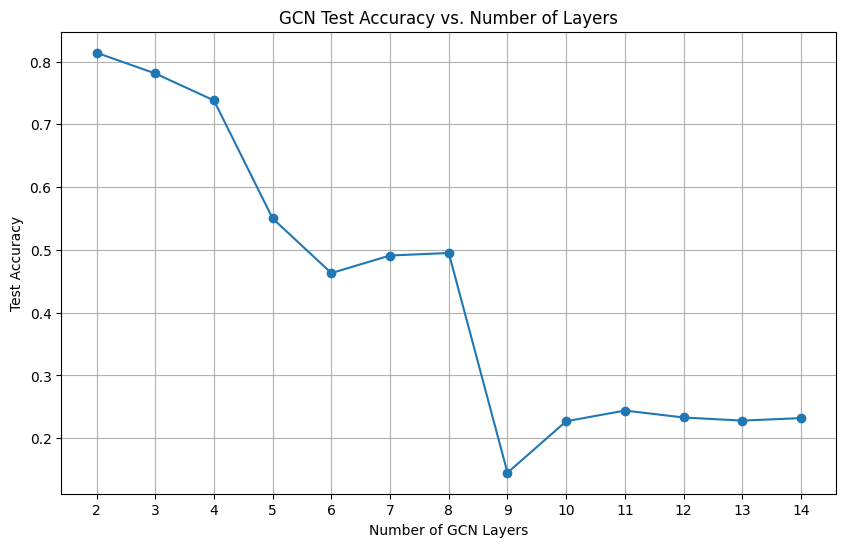

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(test_range, acc_list, marker='o')
plt.title('GCN Test Accuracy vs. Number of Layers')
plt.xlabel('Number of GCN Layers')
plt.ylabel('Test Accuracy')
plt.xticks(test_range)
plt.grid()
plt.show()

### Feature Frequency Analysis

In [67]:
model_inspect = model_list[-1]
out, inspections = model_inspect.forward_inspect(data.x.to(device), data.edge_index.to(device))

In [68]:
for layer_name, activations in inspections.items():
    print(f'Layer: {layer_name}, Activation shape: {activations.shape}')

Layer: conv1, Activation shape: torch.Size([2708, 16])
Layer: conv2, Activation shape: torch.Size([2708, 16])
Layer: conv3, Activation shape: torch.Size([2708, 16])
Layer: conv4, Activation shape: torch.Size([2708, 16])
Layer: conv5, Activation shape: torch.Size([2708, 16])
Layer: conv6, Activation shape: torch.Size([2708, 16])
Layer: conv7, Activation shape: torch.Size([2708, 16])
Layer: conv8, Activation shape: torch.Size([2708, 16])
Layer: conv9, Activation shape: torch.Size([2708, 16])
Layer: conv10, Activation shape: torch.Size([2708, 16])
Layer: conv11, Activation shape: torch.Size([2708, 16])
Layer: conv12, Activation shape: torch.Size([2708, 16])
Layer: conv13, Activation shape: torch.Size([2708, 16])
Layer: conv_out, Activation shape: torch.Size([2708, 7])


Analyzing layers...


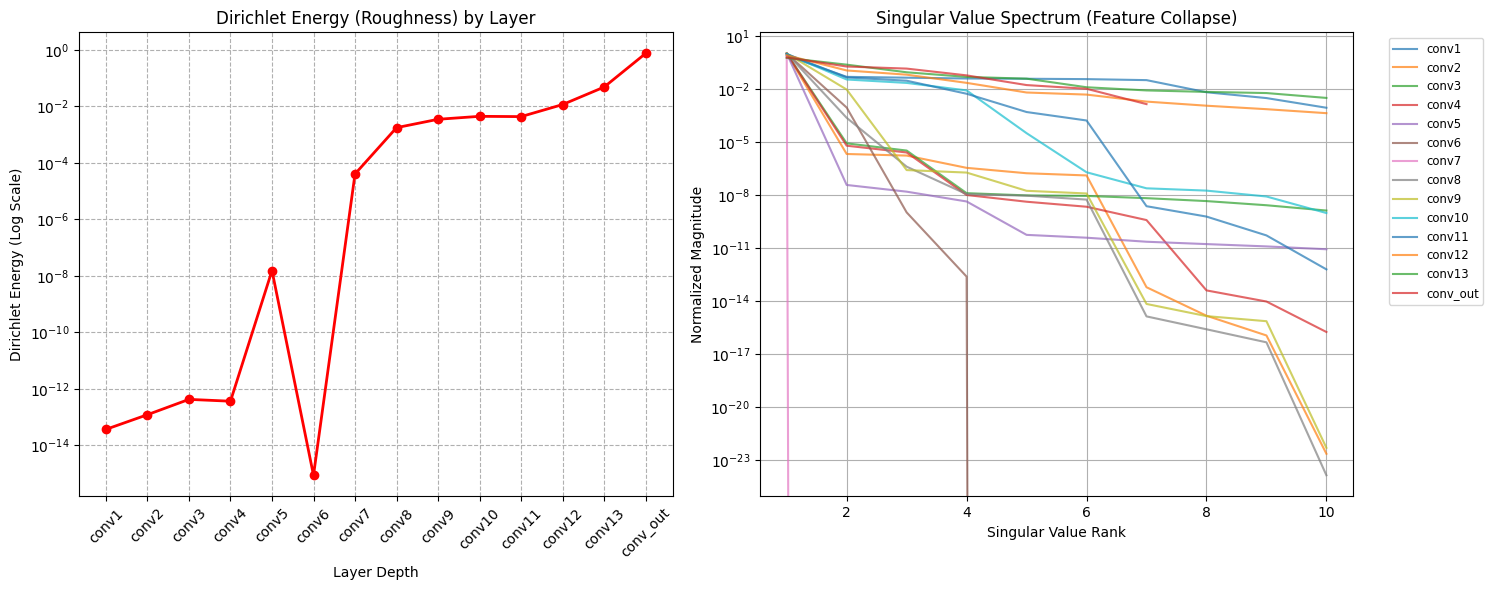

In [69]:
from torch_geometric.utils import get_laplacian, to_dense_adj

def plot_gcn_oversmoothing_analysis(activations_dict, edge_index, num_nodes=2708):
    
    # 1. Laplacian Matrix 
    # L = I - D^(-0.5) A D^(-0.5) (Normalized Laplacian)
    edge_index_lap, edge_weight_lap = get_laplacian(edge_index, normalization='sym')
    L = to_dense_adj(edge_index_lap, edge_attr=edge_weight_lap, max_num_nodes=num_nodes)[0]
    L = L.to(list(activations_dict.values())[0].device) 

    layers = list(activations_dict.keys())
    energies = []
    svd_results = []

    print("Analyzing layers...")
    for layer_name in layers:
        H = activations_dict[layer_name] # Shape: [2708, F]
        
        # --- Analysis 1: Dirichlet Energy ---
        # E = trace(H^T * L * H)
        # normalize by number of nodes and feature dimension for fair comparison
        energy = torch.trace(H.T @ L @ H) / (H.shape[0] * H.shape[1])
        energies.append(energy.item())

        # --- Analysis 2: SVD Spectrum (Effective Rank) ---
        _, S, _ = torch.svd(H)
        # Normalize singular values to sum to 1 (probability distribution like)
        S = S / S.sum()
        svd_results.append(S.cpu().numpy())

    # --- Plotting ---
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Dirichlet Energy Decay
    axes[0].plot(layers, energies, marker='o', linestyle='-', color='r', linewidth=2)
    axes[0].set_title("Dirichlet Energy (Roughness) by Layer")
    axes[0].set_xlabel("Layer Depth")
    axes[0].set_ylabel("Dirichlet Energy (Log Scale)")
    axes[0].set_yscale('log') 
    axes[0].grid(True, which="both", ls="--")
    axes[0].tick_params(axis='x', rotation=45)

    # Plot 2: Singular Value Distributio
    for i, sv in enumerate(svd_results):
        k = min(len(sv), 10) 
        axes[1].plot(range(1, k+1), sv[:k], label=layers[i], alpha=0.7)
    
    axes[1].set_title("Singular Value Spectrum (Feature Collapse)")
    axes[1].set_xlabel("Singular Value Rank")
    axes[1].set_ylabel("Normalized Magnitude")
    axes[1].set_yscale('log')
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_gcn_oversmoothing_analysis(inspections, data.edge_index)

## GCNII-like, or Transformer-like

In [90]:
class GCNNorm(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNNorm, self).__init__()
        self.conv = GCNConv(in_channels, out_channels)
        self.norm = torch_geometric.nn.BatchNorm(out_channels)
    
    def forward(self, x, edge_index):
        out = self.norm(x)
        out = self.conv(out, edge_index)

        return x + out # residual connection

In [91]:
class NormalizedGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super(NormalizedGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2_list = nn.ModuleList(GCNNorm(hidden_channels, hidden_channels) for _ in range(num_layers - 2))
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        for conv in self.conv2_list:
            x = conv(x, edge_index)
            x = self.relu(x)
        x = self.conv3(x, edge_index)
        return x
    
    def forward_inspect(self, x, edge_index):
        inspections = {}
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        inspections['conv1'] = x.detach().cpu()
        for i, conv in enumerate(self.conv2_list):
            x = conv(x, edge_index)
            x = self.relu(x)
            inspections[f'conv{i+2}'] = x.detach().cpu()
        x = self.conv3(x, edge_index)
        inspections['conv_out'] = x.detach().cpu()
        return x, inspections

In [92]:
model_norm = NormalizedGCN(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes, num_layers=3).to(device)
optimizer = torch.optim.Adam(model_norm.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

train(model_norm, data, optimizer, criterion, epochs=200)
accuracy = evaluate(model_norm, data)
print(f'Normalized GCN Test Accuracy: {accuracy:.4f}')

Epoch 20, Loss: 0.0497
Epoch 40, Loss: 0.0026
Epoch 60, Loss: 0.0013
Epoch 80, Loss: 0.0013
Epoch 100, Loss: 0.0015
Epoch 120, Loss: 0.0015
Epoch 140, Loss: 0.0014
Epoch 160, Loss: 0.0013
Epoch 180, Loss: 0.0013
Epoch 200, Loss: 0.0012
Normalized GCN Test Accuracy: 0.7540


In [93]:
norm_model_list = []
norm_acc_list = []

test_range = range(2, 15)

for num_layers in test_range:
    model = NormalizedGCN(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes, num_layers=num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    
    train(model, data, optimizer, criterion, epochs=200)
    accuracy = evaluate(model, data)
    
    norm_model_list.append(model)
    norm_acc_list.append(accuracy)
    
    print(f'Number of Layers: {num_layers}, Test Accuracy: {accuracy:.4f}')

Epoch 20, Loss: 1.6903
Epoch 40, Loss: 1.2300
Epoch 60, Loss: 0.7846
Epoch 80, Loss: 0.5297
Epoch 100, Loss: 0.4012
Epoch 120, Loss: 0.3278
Epoch 140, Loss: 0.2810
Epoch 160, Loss: 0.2490
Epoch 180, Loss: 0.2258
Epoch 200, Loss: 0.2081
Number of Layers: 2, Test Accuracy: 0.8090
Epoch 20, Loss: 0.0424
Epoch 40, Loss: 0.0027
Epoch 60, Loss: 0.0014
Epoch 80, Loss: 0.0014
Epoch 100, Loss: 0.0015
Epoch 120, Loss: 0.0015
Epoch 140, Loss: 0.0015
Epoch 160, Loss: 0.0014
Epoch 180, Loss: 0.0013
Epoch 200, Loss: 0.0012
Number of Layers: 3, Test Accuracy: 0.7220
Epoch 20, Loss: 0.0463
Epoch 40, Loss: 0.0029
Epoch 60, Loss: 0.0014
Epoch 80, Loss: 0.0012
Epoch 100, Loss: 0.0013
Epoch 120, Loss: 0.0013
Epoch 140, Loss: 0.0013
Epoch 160, Loss: 0.0012
Epoch 180, Loss: 0.0012
Epoch 200, Loss: 0.0012
Number of Layers: 4, Test Accuracy: 0.7340
Epoch 20, Loss: 0.0343
Epoch 40, Loss: 0.0029
Epoch 60, Loss: 0.0014
Epoch 80, Loss: 0.0012
Epoch 100, Loss: 0.0013
Epoch 120, Loss: 0.0013
Epoch 140, Loss: 0.0013

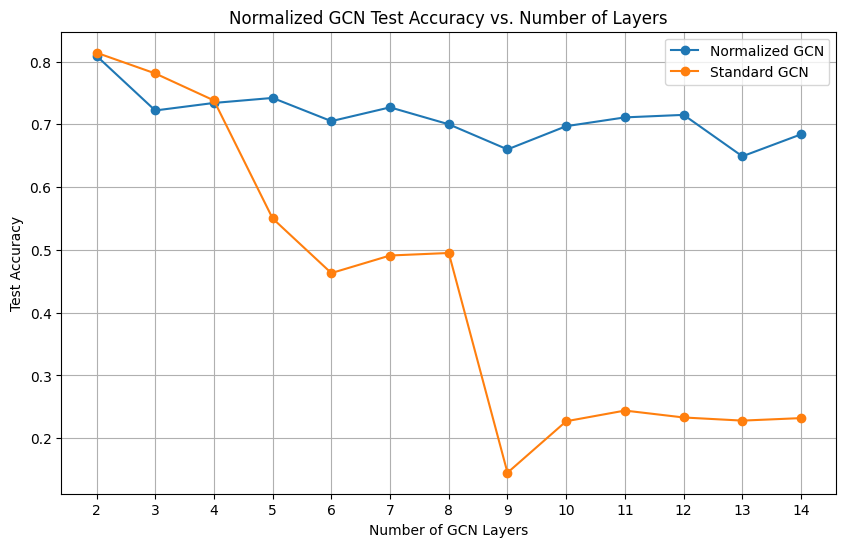

In [95]:
plt.figure(figsize=(10, 6))
plt.plot(test_range, norm_acc_list, marker='o', label='Normalized GCN')
plt.plot(test_range, acc_list, marker='o', label='Standard GCN')
plt.title('Normalized GCN Test Accuracy vs. Number of Layers')
plt.xlabel('Number of GCN Layers')
plt.ylabel('Test Accuracy')
plt.xticks(test_range)
plt.grid()
plt.legend()
plt.show()

In [96]:
norm_model_inspect = norm_model_list[-1]
out, norm_inspections = norm_model_inspect.forward_inspect(data.x.to(device), data.edge_index.to(device))

Analyzing layers...


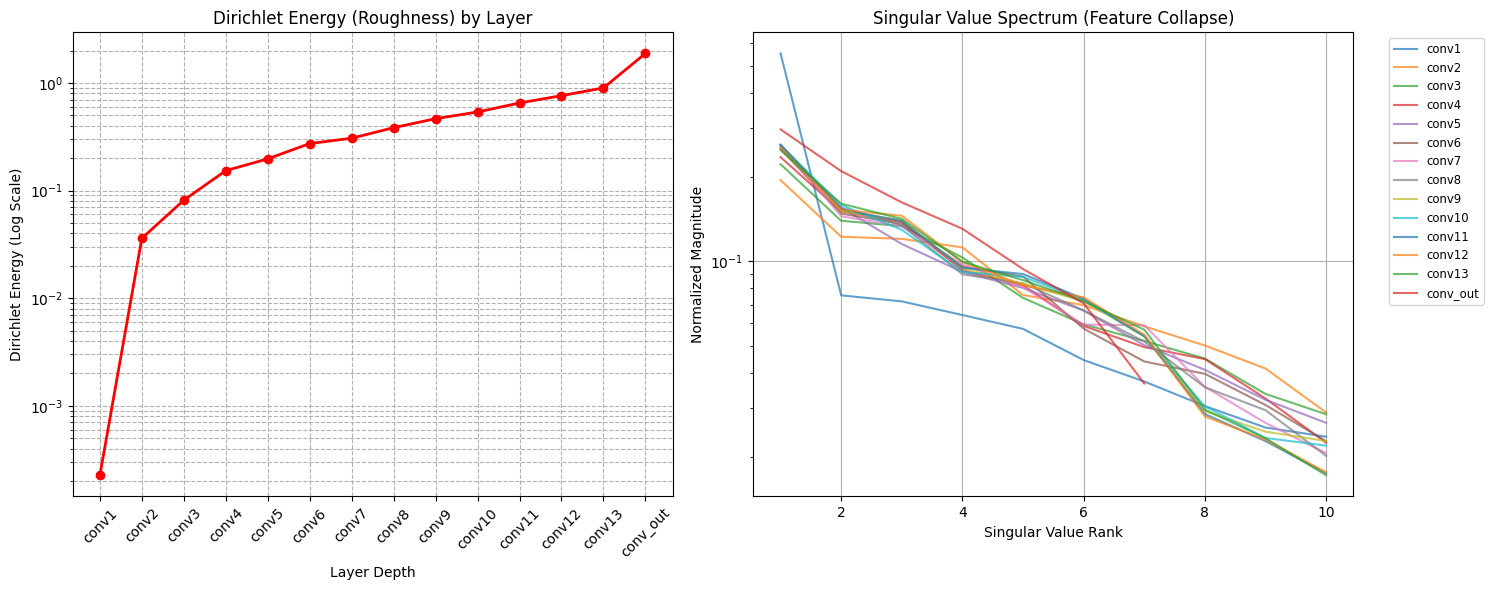

In [97]:
plot_gcn_oversmoothing_analysis(norm_inspections, data.edge_index)

## Blurring-Sharpening layer

In [132]:
class GCNBlurSharpen(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNBlurSharpen, self).__init__()
        self.conv = GCNConv(in_channels, out_channels)
        self.norm = torch_geometric.nn.LayerNorm(out_channels)
        self.alpha = nn.Parameter(torch.ones(out_channels) * 0.5)  # Learnable parameter to balance blur and sharpen
    
    def forward(self, x, edge_index):
        x_norm = self.norm(x)
        out = self.conv(x_norm, edge_index)

        high_freq = x_norm - out
        return x + out + self.alpha * high_freq  # residual with blur and sharpen components

In [133]:
class BSGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super(BSGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2_list = nn.ModuleList(GCNBlurSharpen(hidden_channels, hidden_channels) for _ in range(num_layers - 2))
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        for conv in self.conv2_list:
            x = conv(x, edge_index)
            x = self.relu(x)
        x = self.conv3(x, edge_index)
        return x
    
    def forward_inspect(self, x, edge_index):
        inspections = {}
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        inspections['conv1'] = x.detach().cpu()
        for i, conv in enumerate(self.conv2_list):
            x = conv(x, edge_index)
            x = self.relu(x)
            inspections[f'conv{i+2}'] = x.detach().cpu()
        x = self.conv3(x, edge_index)
        inspections['conv_out'] = x.detach().cpu()
        return x, inspections

In [134]:
model_norm = NormalizedGCN(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes, num_layers=3).to(device)
optimizer = torch.optim.Adam(model_norm.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

train(model_norm, data, optimizer, criterion, epochs=200)
accuracy = evaluate(model_norm, data)
print(f'Normalized GCN Test Accuracy: {accuracy:.4f}')

Epoch 20, Loss: 0.0296
Epoch 40, Loss: 0.0024
Epoch 60, Loss: 0.0014
Epoch 80, Loss: 0.0014
Epoch 100, Loss: 0.0015
Epoch 120, Loss: 0.0015
Epoch 140, Loss: 0.0014
Epoch 160, Loss: 0.0014
Epoch 180, Loss: 0.0013
Epoch 200, Loss: 0.0012
Normalized GCN Test Accuracy: 0.7520


In [148]:
bs_model_list = []
bs_acc_list = []

test_range = range(2, 15)

for num_layers in test_range:
    model = BSGCN(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes, num_layers=num_layers).to(device)

    weights = []
    alphas = []

    for name, param in model.named_parameters():
        if 'alpha' in name:
            alphas.append(param)
        else:
            weights.append(param)
    optimizer = torch.optim.Adam([
        {'params': weights, 'weight_decay': 5e-4, 'lr': 0.01},
        {'params': alphas, 'weight_decay': 0.0, 'lr':0.1}
    ])
    criterion = nn.CrossEntropyLoss()
    
    train(model, data, optimizer, criterion, epochs=200)
    accuracy = evaluate(model, data)
    
    bs_model_list.append(model)
    bs_acc_list.append(accuracy)
    
    print(f'Number of Layers: {num_layers}, Test Accuracy: {accuracy:.4f}')

Epoch 20, Loss: 1.6850
Epoch 40, Loss: 1.2086
Epoch 60, Loss: 0.7787
Epoch 80, Loss: 0.5376
Epoch 100, Loss: 0.4115
Epoch 120, Loss: 0.3382
Epoch 140, Loss: 0.2910
Epoch 160, Loss: 0.2582
Epoch 180, Loss: 0.2341
Epoch 200, Loss: 0.2157
Number of Layers: 2, Test Accuracy: 0.8120
Epoch 20, Loss: 0.0203
Epoch 40, Loss: 0.0005
Epoch 60, Loss: 0.0002
Epoch 80, Loss: 0.0002
Epoch 100, Loss: 0.0002
Epoch 120, Loss: 0.0003
Epoch 140, Loss: 0.0003
Epoch 160, Loss: 0.0003
Epoch 180, Loss: 0.0003
Epoch 200, Loss: 0.0003
Number of Layers: 3, Test Accuracy: 0.7290
Epoch 20, Loss: 0.0544
Epoch 40, Loss: 0.0028
Epoch 60, Loss: 0.0009
Epoch 80, Loss: 0.0007
Epoch 100, Loss: 0.0007
Epoch 120, Loss: 0.0007
Epoch 140, Loss: 0.0006
Epoch 160, Loss: 0.0006
Epoch 180, Loss: 0.0006
Epoch 200, Loss: 0.0006
Number of Layers: 4, Test Accuracy: 0.7770
Epoch 20, Loss: 0.0380
Epoch 40, Loss: 0.0014
Epoch 60, Loss: 0.0005
Epoch 80, Loss: 0.0004
Epoch 100, Loss: 0.0005
Epoch 120, Loss: 0.0005
Epoch 140, Loss: 0.0005

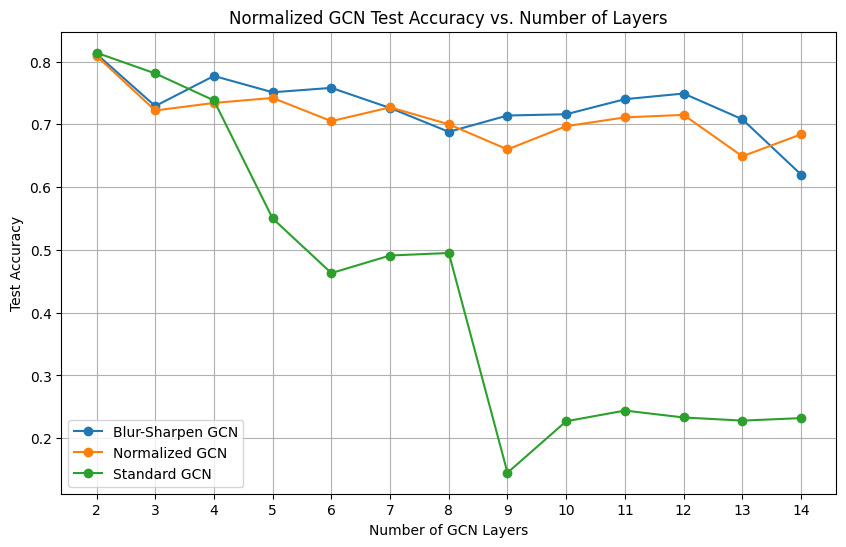

In [149]:
plt.figure(figsize=(10, 6))
plt.plot(test_range, bs_acc_list, marker='o', label='Blur-Sharpen GCN')
plt.plot(test_range, norm_acc_list, marker='o', label='Normalized GCN')
plt.plot(test_range, acc_list, marker='o', label='Standard GCN')
plt.title('Normalized GCN Test Accuracy vs. Number of Layers')
plt.xlabel('Number of GCN Layers')
plt.ylabel('Test Accuracy')
plt.xticks(test_range)
plt.grid()
plt.legend()
plt.show()

In [150]:
bs_model_inspect = bs_model_list[-1]
out, bs_inspections = bs_model_inspect.forward_inspect(data.x.to(device), data.edge_index.to(device))

Analyzing layers...


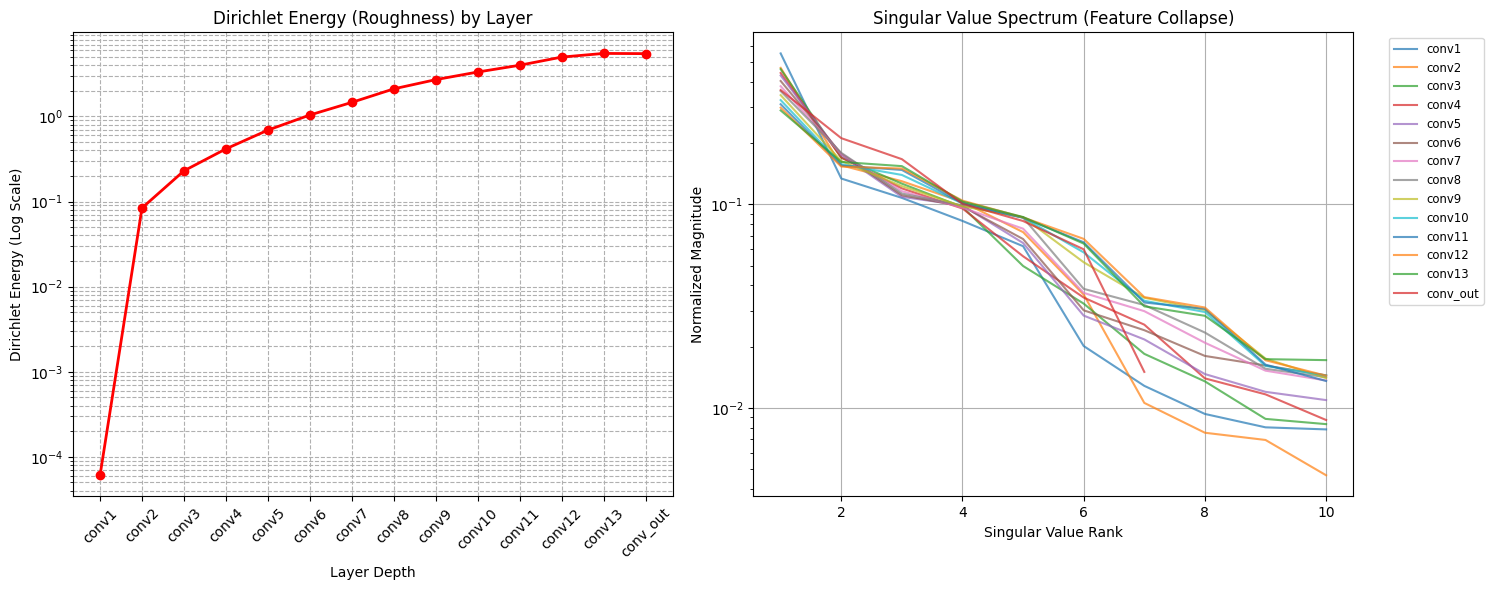

In [151]:
plot_gcn_oversmoothing_analysis(bs_inspections, data.edge_index)

In [153]:
alpha_means = []
for name, param in bs_model_inspect.named_parameters():
    if 'alpha' in name:
        print(f"{name}: {param.data.mean().item()}")
        alpha_means.append(param.data.mean().item())

conv2_list.0.alpha: 0.5795591473579407
conv2_list.1.alpha: 0.5233136415481567
conv2_list.2.alpha: 0.4721336364746094
conv2_list.3.alpha: 0.29911020398139954
conv2_list.4.alpha: 0.3181869685649872
conv2_list.5.alpha: 0.6027572154998779
conv2_list.6.alpha: 0.6992774605751038
conv2_list.7.alpha: -0.015639841556549072
conv2_list.8.alpha: 0.20457176864147186
conv2_list.9.alpha: 0.08303342759609222
conv2_list.10.alpha: 0.3494189381599426
conv2_list.11.alpha: 0.37198352813720703


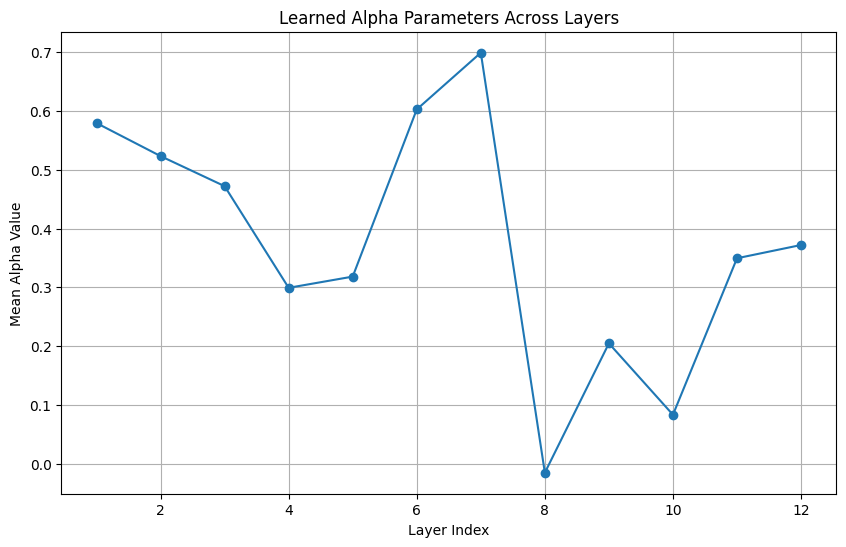

In [154]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(alpha_means)+1), alpha_means, marker='o')
plt.title('Learned Alpha Parameters Across Layers')
plt.xlabel('Layer Index')
plt.ylabel('Mean Alpha Value')
plt.grid()
plt.show()